In [2]:
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.sac import config

In [6]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('logs/tb_logs/sac_220606-1815_1/config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [7]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'n_assets': 1000,
 'n_periods': 30,
 'payoff': 'european',
 'period_unit': 365,
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [8]:
pprint(model_kwargs)

{'action_noise': None,
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'ent_coef': 'auto',
 'env': <Env.env.BSMarket object at 0x00000292AD0459D0>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x00000292CBE558B0>,
 'learning_starts': 300,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.sac.policies.SACPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'clip_mean': 2.0,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
                                                 'features_out': 32,
                                                 'last_activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   

In [9]:
pprint(learn_kwargs)

{'callback': <Algorithms.sac.callbacks.ReportCallbacks object at 0x00000292CBFBE8B0>,
 'eval_env': <Env.env.BSMarket object at 0x00000292CBFBE640>,
 'eval_freq': 30,
 'eval_log_path': 'logs/tb_logs/sac_220606-1815_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'sac_220606-1815',
 'total_timesteps': 1500}


In [13]:
from Env.env import BSMarket
env: BSMarket = model_kwargs['env']

In [14]:
env

In [45]:
import numpy as np
def diff():
    loss = []
    for i in range(env.n_periods-1):
        ud = env.underlying_prices[i+1]-env.underlying_prices[i]
        od = env.option_prices[i+1]-env.option_prices[i]
        delta = env.delta[i]
        # delta = np.random.randn(env.n_assets)
        loss.append(np.sqrt(np.mean((delta - abs(od/ud))**2)))

    return loss

105.22455415106411


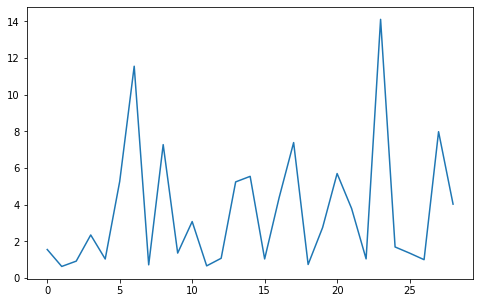

In [46]:
import matplotlib.pyplot as plt

loss = diff()
plt.figure(figsize=(8,5))
plt.plot(loss)
print(sum(loss))

In [41]:
loss

[1.9433482838386313,
 1.2987101479089331,
 1.4686135945025165,
 2.5880216574821686,
 1.5317858807124172,
 5.3818061307889185,
 11.665813785158463,
 1.3924455634610464,
 7.447207302169786,
 1.8446550926878627,
 3.3119966674950767,
 1.3397757141549305,
 1.6312158886128305,
 5.411556942344414,
 5.759919540131907,
 1.5638784708587563,
 4.56201394095296,
 7.539710208548795,
 1.447028814711834,
 3.007336877166069,
 5.867456962485464,
 3.9857703590518216,
 1.6160175245586799,
 14.20619646818864,
 2.088119267945805,
 1.8670939357572796,
 1.6140773915863302,
 8.101041938384677,
 4.244062969096549]